## K-Means Clustering Implementation

### Algorithm

Let X={x1,x2⋯xn} X={x1,x2⋯xn} be the set of data points

Let V={v1,v2⋯vc} V={v1,v2⋯vc} be the set of cluster centers

1. Randomly select 'c' cluster centers
2. Compute the distance between each data point and each cluster center
3. Assign each data point to its nearest cluster
4. Recompute the new cluster centers based on the points assigned to it.
5. Recompute the distance between each data point and the new cluster centers
6. If no data point was reassigned then stop, otherwise repeat from Step 3

The result is saved in a gif

Cristobal Valenzuela

Learning Machines class by Patrick Hebron @ NYU ITP

2017

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from scipy.spatial import Voronoi

In [18]:
# Step 1
# Randomly select 'c' cluster centers and points
amount_of_points = 200
amount_of_clusters = 7

points = np.random.random((amount_of_points,2))
clusters = np.random.random((amount_of_clusters,2))
points_to_clusters = np.zeros(amount_of_points)
previous_points_to_clusters = np.ones(amount_of_points)

iterations = 0
images = []

In [19]:
# Step 2,3 and 5,6
# Compute the distance between each data point and each cluster center and
# assign each data point to its nearest cluster
def pointToNearestCluster():
    global previous_points_to_clusters
    global iterations
    if not np.array_equal(previous_points_to_clusters, points_to_clusters):
        previous_points_to_clusters = np.copy(points_to_clusters)
        iterations += 1
        for pointIndex, point in enumerate(points):
            distance_to_closest_cluster = 1
            closest_cluster = 0
            for clusterIndex, cluster in enumerate(clusters):
                distance = np.linalg.norm(point - cluster)
                if distance < distance_to_closest_cluster:
                    distance_to_closest_cluster = distance
                    closest_cluster = clusterIndex
            points_to_clusters[pointIndex] = closest_cluster
        plotPointsAndClusters()
        getClustersCenter()
        
    else:
        plotPointsAndClusters()
        createGif()

In [20]:
# Step 4
# Recompute the new cluster centers based on the points assigned to it
def getClustersCenter():
    for i in range(amount_of_clusters):
        sum_of_points = np.zeros((1,2))
        points_in_cluster = np.argwhere(points_to_clusters == i)
        for p in points_in_cluster:
            sum_of_points += points[p[0]]

        avg = sum_of_points/len(points_in_cluster)
        clusters[i] = avg
    pointToNearestCluster()

In [21]:
# Plot points and clusters
def plotPointsAndClusters():
    plt.axis( [ 0, 1, 0, 1 ] )
    plt.title('Iteration N' + str(iterations))
    
    # compute Voronoi tesselation
    vor = Voronoi(clusters)
    # plot
    regions, vertices = voronoi_finite_polygons_2d(vor)
    # colorize
    for region in regions:
        polygon = vertices[region]
        plt.fill(*zip(*polygon), alpha=0.4)

    plt.plot(points[:,0],points[:,1], 'go', markersize=2)
    plt.plot(clusters[:,0],clusters[:,1], 'ro', markersize=4)
    #plt.axis('equal')
    #plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    #plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

    plt.savefig(str(iterations) + '.jpg', dpi=100)
    plt.show()

In [22]:
# Create gif with all saved images and delete the images
def createGif():
    for i in range(iterations):
        if i > 0:
            images.append(imageio.imread(str(i)+'.jpg'))
    imageio.mimsave('animation.gif', images, duration=1)
    
    for img in os.listdir():
        if img.endswith('.jpg'):
            os.remove(img) 

In [23]:
# Creates a colorized voronoi.
# Taken from https://gist.github.com/pv/8036995
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

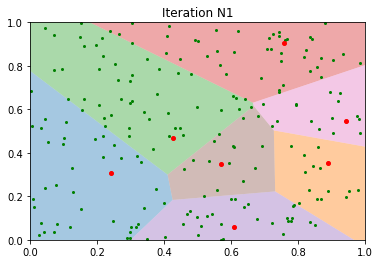

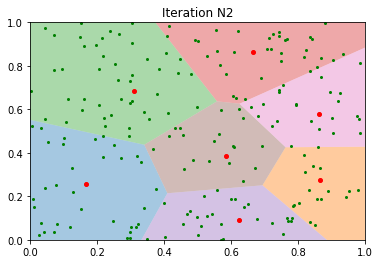

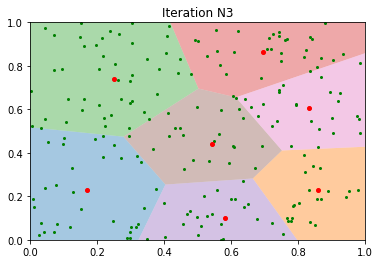

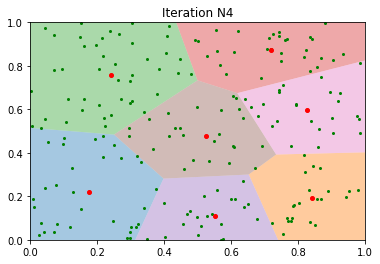

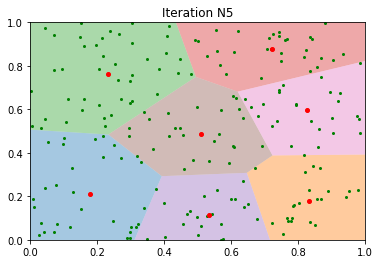

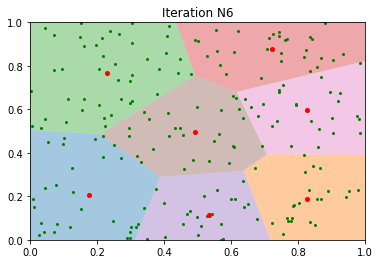

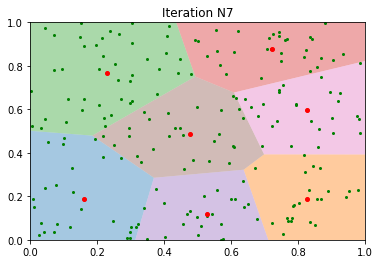

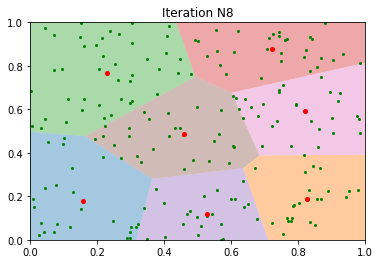

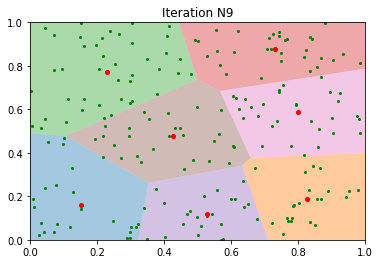

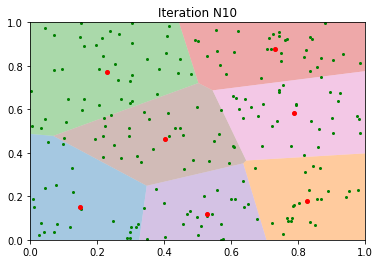

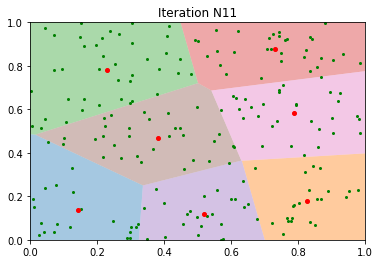

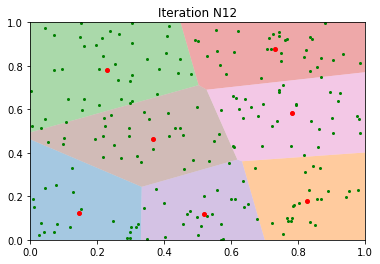

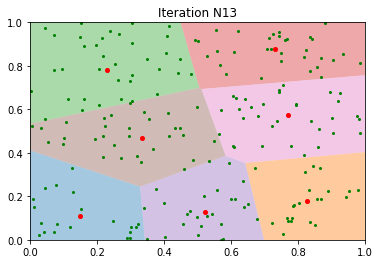

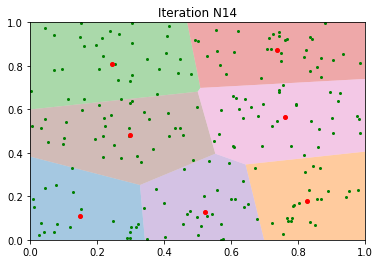

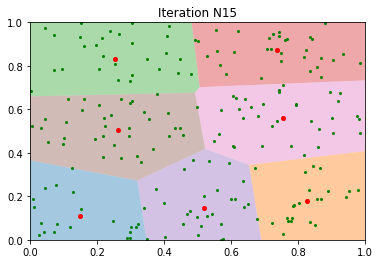

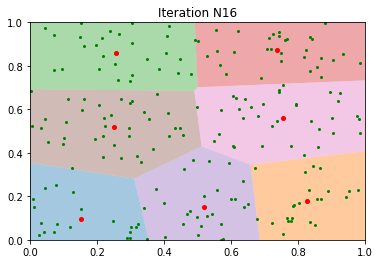

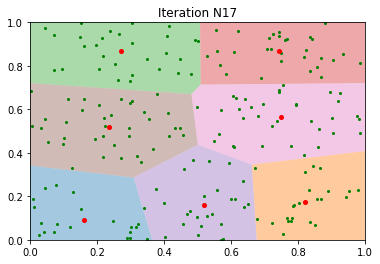

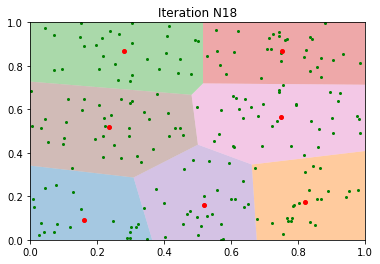

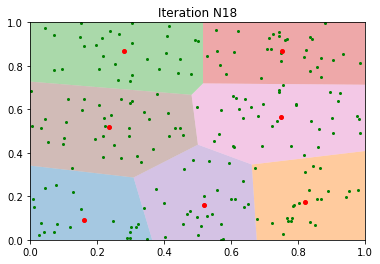

In [24]:
# Start
pointToNearestCluster()